# Playground

In the notebook you can use to run the pipeline on

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

from ext.DeepLSD.deeplsd.models.deeplsd_inference import DeepLSD
from ext.DeepLSD.deeplsd.geometry.viz_2d import plot_images, plot_lines
import pyprogressivex
from random import randint

from yud import YUDVP
from matplotlib.patches import Patch
from ext.PerspectiveFields.perspective2d import PerspectiveFields
import os
import gc
import time
from ext.GeoCalib.geocalib.extractor import GeoCalib

from pytlsd import lsd

/home/tab/Desktop/EPFL/MA2/test/cs413-project/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Code for the pipeline

In [3]:
def get_line_segments_deepLSD(img, model='default', show_detected_lines=False):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cpu')
    conf = {
        'detect_lines': True,  # Whether to detect lines or only DF/AF
        'line_detection_params': {
            'merge': True,  # Whether to merge close-by lines
            'filtering': 'strict',
            # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
            'grad_thresh': 3,
            'grad_nfa': True,
            # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
        }
    }

    # Load the model
    if model == 'default':
        ckpt = "ext/DeepLSD/weights/deeplsd_md.tar"
    elif model == 'wireframe':
        ckpt = "ext/DeepLSD/weights/deeplsd_wireframe.tar"
    else:
        raise ValueError("Invalid model name. Use 'default' or 'wireframe'.")
    ckpt = torch.load(str(ckpt), map_location='cpu', weights_only=False)
    net = DeepLSD(conf)
    net.load_state_dict(ckpt['model'])
    net = net.to(device).eval()

    tensor = torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.

    inputs = {'image': tensor}

    with torch.no_grad():
        out = net(inputs)
        pred_lines = out['lines'][0]

    if show_detected_lines:
        plot_images([img], ['DeepLSD lines'], cmaps='gray')
        plot_lines([pred_lines], indices=range(1))
        plt.show()

    # Transform the detected lines to the format of LSD
    detected_linesegments = np.zeros((pred_lines.shape[0], 5))
    for i in range(pred_lines.shape[0]):
        pt1_x = pred_lines[i, 0, 0]
        pt1_y = pred_lines[i, 0, 1]
        pt2_x = pred_lines[i, 1, 0]
        pt2_y = pred_lines[i, 1, 1]
        pt1 = np.array([pt1_x, pt1_y])
        pt2 = np.array([pt2_x, pt2_y])
        dist = np.linalg.norm(pt1 - pt2)
        detected_linesegments[i, :] = [pt1_x, pt1_y, pt2_x, pt2_y, dist]
    detected_linesegments[:, 4] /= np.sum(detected_linesegments[:, 4])

    del inputs
    del pred_lines
    del out
    gc.collect()
    torch.cuda.empty_cache()

    if show_detected_lines:
        # Save the image with detected lines to default folder
        path = 'data/DeepLSD/linesegments'
        os.makedirs(path, exist_ok=True)
        line_img = img.copy()

        for i in range(detected_linesegments.shape[0]):
            # Convert the line to its implicit form
            pt1 = np.array([detected_linesegments[i, 0], detected_linesegments[i, 1]])
            pt2 = np.array([detected_linesegments[i, 2], detected_linesegments[i, 3]])
            v = pt2 - pt1
            line_length = np.linalg.norm(v)

            if line_length < 0:
                continue

            # Draw the line
            pt1i = (int(detected_linesegments[i, 0]), int(detected_linesegments[i, 1]))
            pt2i = (int(detected_linesegments[i, 2]), int(detected_linesegments[i, 3]))
            width = 3  # detected_linesegments[i, 4]
            cv2.line(line_img, pt1i, pt2i, (255, 255, 255), int(np.ceil(width / 2)))

        full_save_path = os.path.join(path, 'detected_linesegments.png')
        cv2.imwrite(full_save_path, line_img)

    return detected_linesegments


def get_line_segments_LSD(img, show_detected_lines=False):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    pred_lines = lsd(gray_img, density_th=0.0)

    if show_detected_lines:
        length_threshold = 0
        linesegments = []
        lengths = []

        #Shows image
        line_img = img.copy()
        for i in range(pred_lines.shape[0]):
            # Convert the line to its implicit form
            pt1 = np.array([pred_lines[i, 0], pred_lines[i, 1]])
            pt2 = np.array([pred_lines[i, 2], pred_lines[i, 3]])
            v = pt2 - pt1
            line_length = np.linalg.norm(v)

            if line_length < length_threshold:
                continue

            lengths.append(line_length)
            linesegments.append(pred_lines[i, :])

            # Draw the line
            pt1i = (int(pred_lines[i, 0]), int(pred_lines[i, 1]))
            pt2i = (int(pred_lines[i, 2]), int(pred_lines[i, 3]))
            width = 3  # detected_linesegments[i, 4]
            cv2.line(line_img, pt1i, pt2i, (0, 0, 255), int(np.ceil(width / 2)))
        plt.imshow(line_img)

    # Transforms the detected lines to the format of LSD
    detected_linesegments = np.zeros((pred_lines.shape[0], 5))
    for i in range(pred_lines.shape[0]):
        pt1_x = pred_lines[i, 0]
        pt1_y = pred_lines[i, 1]
        pt2_x = pred_lines[i, 2]
        pt2_y = pred_lines[i, 3]
        pt1 = np.array([pt1_x, pt1_y])
        pt2 = np.array([pt2_x, pt2_y])
        dist = np.linalg.norm(pt1 - pt2)
        detected_linesegments[i, :] = [pt1_x, pt1_y, pt2_x, pt2_y, dist]
    detected_linesegments[:, 4] /= np.sum(detected_linesegments[:, 4])
    # Converts to numpy array
    detected_linesegments = np.array(detected_linesegments)
    return detected_linesegments


def get_vanishing_points(img, linesegments, threshold=0.1, minimum_point_number=2, maximum_model_number=-1):
    def verify_pyprogressivex(img, lines, weights, threshold=2.0):
        vanishing_points, labeling = pyprogressivex.findVanishingPoints(
            np.ascontiguousarray(lines),
            np.ascontiguousarray(weights),
            img.shape[1], img.shape[0],
            threshold=threshold,
            conf=0.99,
            spatial_coherence_weight=0.0,
            neighborhood_ball_radius=1.0,
            maximum_tanimoto_similarity=1.0,
            max_iters=1_000_000,
            minimum_point_number=minimum_point_number,
            maximum_model_number=maximum_model_number,
            sampler_id=0,
            scoring_exponent=1.0,
            do_logging=False)
        return vanishing_points, labeling

    linesegments[:, 4] /= np.sum(linesegments[:, 4])
    vanishing_points, labeling = verify_pyprogressivex(img, linesegments[:, 0:4], linesegments, threshold=threshold)
    predicted_vanishing_points = []

    model_number = int(vanishing_points.size / 3)

    for idx in range(model_number):
        vp = vanishing_points[idx]

        if abs(vp[2]) < 1e-10:
            continue

        vp /= vp[2]
        vp = (int(vp[0]), int(vp[1]))

        predicted_vanishing_points.append(vp)

    return np.array(predicted_vanishing_points), labeling


def display_vanishing_points(img, linesegments, vanishing_points, labeling, display_outliers=False, is_manhattan=None):
    line_img = img.copy()
    model_number = vanishing_points.shape[0]

    legend_patches = []

    colours = [
        [255, 0, 0],  # Red
        [0, 255, 0],  # Green
        [0, 0, 255],  # Blue
        [255, 255, 0],  # Yellow
        [0, 255, 255],  # Cyan
        [255, 0, 255],  # Magenta
        [128, 0, 0],  # Dark Red
        [0, 128, 0],  # Dark Green
        [0, 0, 128],  # Dark Blue
        [255, 165, 0],  # Orange
        [255, 192, 203],  # Pink
        [75, 0, 130],  # Indigo
        [0, 128, 128],  # Teal
        [128, 0, 128],  # Purple
    ]
    num_of_colours = len(colours)

    if display_outliers:
        idx = model_number
        indices = [i for i, e in enumerate(labeling) if e == idx]
        color = (255, 255, 255)

        # OpenCV uses BGR, matplotlib uses RGB
        color_rgb = tuple([c / 255. for c in color[::-1]])
        legend_label = f"Outliers: {len(indices)} lines"
        legend_patches.append(Patch(color=color_rgb, label=legend_label))
        print(f"Drawing the lines assigned to the outliers. Label: {idx}")
        print(f"# inliers = {len(indices)}")
        for i in indices:
            pt1i = (int(linesegments[i, 0]), int(linesegments[i, 1]))
            pt2i = (int(linesegments[i, 2]), int(linesegments[i, 3]))
            width = 6  # static width; could be dynamic
            cv2.line(line_img, pt1i, pt2i, color, int(np.ceil(width / 2)))

    for idx in range(model_number):
        indices = [i for i, e in enumerate(labeling) if e == idx]
        if idx < num_of_colours:
            color = colours[idx]
        else:
            color = (randint(0, 255), randint(0, 255), randint(0, 255))

        # OpenCV uses BGR, matplotlib uses RGB
        color_rgb = tuple([c / 255. for c in color[::-1]])
        print('vanishing_points[idx]:', vanishing_points[idx], type(vanishing_points[idx]))
        legend_label = f"VP {idx}: {tuple(map(int, vanishing_points[idx]))}"

        legend_patches.append(Patch(color=color_rgb, label=legend_label))

        vp = tuple(map(int, vanishing_points[idx]))

        print(f"Drawing the lines assigned to the {int(idx + 1)}-th vanishing point.")
        print(f"# inliers = {len(indices)}")

        for i in indices:
            pt1i = (int(linesegments[i, 0]), int(linesegments[i, 1]))
            pt2i = (int(linesegments[i, 2]), int(linesegments[i, 3]))
            width = 3  # static width; could be dynamic
            cv2.line(line_img, pt1i, pt2i, color, int(np.ceil(width / 2)))

        # Draw vanishing point as white border, then color
        cv2.circle(line_img, vp, 5, (255, 255, 255), -1)
        cv2.circle(line_img, vp, 3, color, -1)

    if is_manhattan is not None:
        legend_patches.append(
            Patch(color='gray', label=f"Is Manhattan = {is_manhattan}")
        )

    # Convert BGR to RGB for matplotlib
    line_img_rgb = cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(line_img_rgb)
    plt.axis('off')
    plt.legend(handles=legend_patches, loc='upper right')
    plt.show()


def save_vanishing_points(
        img, linesegments, vanishing_points, labeling,
        save_path, name, display_outliers=False, is_manhattan=None
):
    line_img = img.copy()
    model_number = vanishing_points.shape[0]

    colours = [
        [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0],
        [0, 255, 255], [255, 0, 255], [128, 0, 0], [0, 128, 0],
        [0, 0, 128], [255, 165, 0], [255, 192, 203], [75, 0, 130],
        [0, 128, 128], [128, 0, 128],
    ]
    num_of_colours = len(colours)
    width = 3

    legend_patches = []

    # Draw outliers if requested
    if display_outliers:
        idx = model_number
        indices = [i for i, e in enumerate(labeling) if e == idx]
        color = (255, 255, 255)
        color_rgb = tuple([c / 255. for c in color[::-1]])
        legend_label = f"Outliers: {len(indices)} lines"
        legend_patches.append(Patch(color=color_rgb, label=legend_label))
        for i in indices:
            pt1 = tuple(map(int, linesegments[i, 0:2]))
            pt2 = tuple(map(int, linesegments[i, 2:4]))
            cv2.line(line_img, pt1, pt2, color, int(np.ceil(width / 2)))

    # Draw vanishing point lines and add legend
    for idx in range(model_number):
        indices = [i for i, e in enumerate(labeling) if e == idx]
        if idx < num_of_colours:
            color = colours[idx]
        else:
            color = (randint(0, 255), randint(0, 255), randint(0, 255))
        color_tuple = tuple(int(c) for c in color)
        color_rgb = tuple([c / 255. for c in color[::-1]])
        legend_label = f"VP {idx}: {tuple(map(int, vanishing_points[idx]))}"
        legend_patches.append(Patch(color=color_rgb, label=legend_label))

        vp = tuple(map(int, vanishing_points[idx]))
        for i in indices:
            pt1 = tuple(map(int, linesegments[i, 0:2]))
            pt2 = tuple(map(int, linesegments[i, 2:4]))
            cv2.line(line_img, pt1, pt2, color_tuple, int(np.ceil(width / 2)))
        # Draw vanishing point: white border then colored center
        cv2.circle(line_img, vp, 5, (255, 255, 255), -1)
        cv2.circle(line_img, vp, 3, color_tuple, -1)

    if is_manhattan is not None:
        legend_patches.append(
            Patch(color='gray', label=f"Is Manhattan = {is_manhattan}")
        )

    # Convert BGR to RGB for Matplotlib
    line_img_rgb = cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB)

    # Plot and save with legend
    plt.figure(figsize=(12, 8))
    plt.imshow(line_img_rgb)
    plt.axis('off')
    plt.legend(handles=legend_patches, loc='upper right', fontsize=14, frameon=True)
    os.makedirs(save_path, exist_ok=True)
    full_save_path = os.path.join(save_path, name)
    plt.savefig(full_save_path, bbox_inches='tight', pad_inches=0.1, dpi=200)
    plt.close()


def predict_camera_parameters(image, model):
    if type(model) == PerspectiveFields:
        prediction = model.inference(img_bgr=image)

        roll = prediction['pred_roll'].cpu().numpy()
        pitch = prediction['pred_pitch'].cpu().numpy()
        vfov = prediction['pred_general_vfov'].cpu().numpy()
        focal_length = prediction['pred_rel_focal'].cpu().numpy() * image.shape[0]

        return roll, pitch, vfov, focal_length, prediction

    elif type(model) == GeoCalib:
        img_tensor = torch.tensor(image).permute(2, 0, 1) / 255.0
        image_tensor = img_tensor.to(device)
        prediction = model.calibrate(image_tensor)

        del image_tensor

        roll = prediction['camera'].roll.item()
        pitch = prediction['camera'].pitch.item()
        vfov = prediction['camera'].vfov.item()
        focal_length = prediction['camera'].f[0, 1].item()

        return roll, pitch, vfov, focal_length, prediction
    else:
        raise ValueError(f"Unknown model: {type(model)}")


def generate_camera_intrinsics(img, cx, cy, focal_length):
    # Generate camera intrinsics
    K = np.zeros((3, 3))
    K[0, 0] = focal_length
    K[1, 1] = focal_length
    K[0, 2] = cx * img.shape[1] + img.shape[1] / 2
    K[1, 2] = cy * img.shape[0] + img.shape[0] / 2
    K[2, 2] = 1.0

    return K


def compare_vp_to_groundtruth(vp, gt_vp):
    # Compares the predicted vanishing points array to the ground truth array using angular distance

    angular_matrix = np.zeros((len(gt_vp), len(vp)))
    for i, true_vp in enumerate(gt_vp):
        for j, pred_vp in enumerate(vp):
            dist = np.arccos(np.dot(true_vp, pred_vp) / (np.linalg.norm(true_vp) * np.linalg.norm(pred_vp)))
            angular_matrix[i, j] = dist

    # For each true vp, we find the closest predicted vp by angular distance
    best_matches = np.min(angular_matrix, axis=1)
    best_matches = np.degrees(best_matches)
    return best_matches


def extract_dataset_items(dataset, idx):
    sample = dataset[idx]  # get a single sample from the dataset
    vp_gt_hom = sample['VPs']  # array Mx3 with vanishing points in homogeneous coordinates
    image = sample['image']  # RGB image
    lines = sample['line_segments']  # array Nx12 containing all extracted line segments
    p1 = lines[:, 0:3]  # line segment start points in hom. coordinates
    p2 = lines[:, 3:6]  # line segment end points in hom. coordinates
    hom_lines = lines[:, 6:9]  # parametrised line [a,b,c] s.t. ax+by+c=0
    centroids = lines[:, 9:12]  # centroid = (p1+p2)/2.

    vp0 = vp_gt_hom[0]
    vp1 = vp_gt_hom[1]
    vp2 = vp_gt_hom[2]

    vp0 = vp0 / vp0[2]
    vp1 = vp1 / vp1[2]
    vp2 = vp2 / vp2[2]

    vp0 = (int(vp0[0]), int(vp0[1]))
    vp1 = (int(vp1[0]), int(vp1[1]))
    vp2 = (int(vp2[0]), int(vp2[1]))

    vp_gt = [vp0, vp1, vp2]

    return image, sample, vp_gt


def is_manhattan_triple(vps, K, threshold=0.15) -> (bool, float, float, float):
    """
    Returns True if the three vanishing points form a Manhattan frame.
    vanishing_points: list of three [x, y] vanishing points
    K: camera intrinsic matrix (3x3)
    threshold: maximum allowed absolute dot product (cosine of angle) for orthogonality
    """

    if len(vps) < 3:
        # Not enough vanishing points
        return False, np.nan, np.nan, np.nan

    if vps.shape[1] == 2:
        vps = np.c_[vps, np.ones(3)]

    K_inv = np.linalg.inv(K)
    dirs = (K_inv @ vps.T).T  # shape (3,3)
    dirs /= np.linalg.norm(dirs, axis=1, keepdims=True)

    dot12 = np.dot(dirs[0], dirs[1])
    dot23 = np.dot(dirs[1], dirs[2])
    dot31 = np.dot(dirs[2], dirs[0])
    dots = np.array([dot12, dot23, dot31])

    ok = np.all(np.abs(dots) < threshold)
    return ok, dot12, dot23, dot31


def extract_segments_by_label(linesegments, labels, L):
    """
    Extract all line segments of label L.

    Parameters:
        linesegments: numpy array of shape (N, 5)
        labels: array-like of shape (N,)
        L: label value to extract

    Returns:
        segments_with_label_L: numpy array of shape (M, 5) for label L
        indices: numpy array of shape (M,) for the indices of the segments with label L
    """
    linesegments = np.asarray(linesegments)
    labels = np.asarray(labels)
    mask = (labels == L)
    indices = np.where(mask)[0]
    return linesegments[mask], indices


def label_map_to_label_array(segments, segment_to_label, missing_value=-1):
    """
    Converts the segment_to_label map to a label array.

    Args:
        segments (list): List of segment tuples [(x1, y1, x2, y2), ...].
        segment_to_label (dict): Map from segment tuple to label (int).
        missing_value (int): Value to use if a segment is not found in the map.

    Returns:
        list: List of labels corresponding to each segment.
    """
    return [
        segment_to_label.get(tuple(int(x) for x in seg), missing_value)
        for seg in segments
    ]


def update_label_map(segment_to_label, segments_to_update, labels_to_update):
    """
    Update the label map with new labels for a set of segments.

    Parameters:
        segment_to_label: dictionary mapping segment index to label
        segments_to_update: numpy array of shape (M,) with the subset of segments to update
        labels_to_update: numpy array of shape (M,) with the new labels for the subset of segments
    """
    for i, label in enumerate(labels_to_update):
        segment = segments_to_update[i]
        segment_tuple = tuple(np.asarray(segment, dtype=int))  # Convert numpy array to tuple for hashing
        segment_to_label[segment_tuple] = label
    return segment_to_label


def pipeline(image, K, line_detector='both', vp_threshold=2.0, refinement_threshold=1.0, manhattan_threshold=0.15, do_refinement=True, verbose=False, refinement_stragegy='default'):
    """
    Main pipeline function to process an image and extract vanishing points.

    Parameters:
        image: input image
        K: camera intrinsic matrix (3x3)
        line_detector: 'lsd+deeplsd', 'lsd+deeplsd-wireframe', 'deeplsd', 'deeplsd-wireframe', or 'lsd'
        vp_threshold: threshold for vanishing point detection
        refinement_threshold: threshold for refinement step
        manhattan_threshold: threshold for Manhattan frame check


    Returns:
        None
    """
    show_detected_lines = False
    if verbose:
        show_detected_lines = True

    if line_detector == 'lsd+deeplsd':
        deeplsd_line_segments = get_line_segments_deepLSD(image, model='default', show_detected_lines=show_detected_lines)
        lsd_line_segments = get_line_segments_LSD(image, show_detected_lines=show_detected_lines)
        line_segments = np.concatenate((deeplsd_line_segments, lsd_line_segments), axis=0)
    elif line_detector == 'lsd+deeplsd-wireframe':
        deeplsd_line_segments = get_line_segments_deepLSD(image, model='wireframe', show_detected_lines=show_detected_lines)
        lsd_line_segments = get_line_segments_LSD(image, show_detected_lines=show_detected_lines)
        line_segments = np.concatenate((deeplsd_line_segments, lsd_line_segments), axis=0)
    elif line_detector == 'deeplsd':
        line_segments = get_line_segments_deepLSD(image, model='default', show_detected_lines=show_detected_lines)
    elif line_detector == 'deeplsd-wireframe':
        line_segments = get_line_segments_deepLSD(image, model='wireframe', show_detected_lines=show_detected_lines)
    elif line_detector == 'lsd':
        line_segments = get_line_segments_LSD(image, show_detected_lines=show_detected_lines)
    else:
        raise ValueError("Invalid line detector. Use 'lsd+deeplsd', 'lsd+deeplsd-wireframe', 'deeplsd', 'deeplsd-wireframe', or 'lsd'.")

    if line_segments.shape[0] < 6:
        print(f"⚠️ Warning: Reverted to LSD because {line_detector} could not find enough line segments.")
        line_segments = get_line_segments_LSD(image, show_detected_lines=show_detected_lines)

    if verbose:
        print(f"Detected {line_segments.shape[0]} line segments.")

    # Get initial vanishing points
    initial_vanishing_points, initial_labeling = get_vanishing_points(image, line_segments, threshold=vp_threshold,
                                                      minimum_point_number=2, maximum_model_number=3)

    segment_to_label = {}
    for segment, label in zip(line_segments, initial_labeling):
        segment_tuple = tuple(int(x) for x in segment)
        segment_to_label[segment_tuple] = label


    if verbose:
        print(f"Initial vanishing points ({initial_vanishing_points.shape[0]}): \n {initial_vanishing_points}")
        print("Type of initial_vanishing_points: ", type(initial_vanishing_points))
        print("Shape of initial_vanishing_points: ", initial_vanishing_points.shape)
        print("Type of line_segments: ", type(line_segments))
        print("Shape of line_segments: ", line_segments.shape)
        labels = label_map_to_label_array(line_segments, segment_to_label)
        display_vanishing_points(image, line_segments, initial_vanishing_points, labels, display_outliers=True)

    # Checks if the initial vanishing points form a Manhattan frame
    is_manhattan, dot01, dot12, dot20 = is_manhattan_triple(initial_vanishing_points, K, threshold=manhattan_threshold)

    if verbose:
        print(f"Is inital VP a Manhattan frame: {is_manhattan}")
        print(f"Inital VP Dot products (dot01, dot12, dot20): {dot01}, {dot12}, {dot20}")

    # If not a Manhattan frame, refine the vanishing points
    if not is_manhattan and do_refinement:
        if not is_manhattan and np.any(np.isnan([dot01, dot12, dot20])):
            if verbose: print("No Manhattan frame detected. Refinement not possible.")
            return False, initial_vanishing_points, label_map_to_label_array(line_segments, segment_to_label), line_segments, (dot01, dot12, dot20)

        if abs(dot01) >= 0.5:
            label_A = 0
            label_B = 1
            label_fixed = 2
            dot = dot01
            if verbose: print("dot01 >= 0.5")
        elif abs(dot12) >= 0.5:
            label_fixed = 0
            label_A = 1
            label_B = 2
            dot = dot12
            if verbose: print("dot12 >= 0.5")
        elif abs(dot20) >= 0.5:
            label_A = 2
            label_fixed = 1
            label_B = 0
            dot = dot20
            if verbose: print("dot20 >= 0.5")
        else:
            if verbose: print("No Manhattan frame detected. Refinement not possible.")
            return False, initial_vanishing_points, label_map_to_label_array(line_segments, segment_to_label), line_segments, (dot01, dot12, dot20)

        first_vp = initial_vanishing_points[label_fixed]

        # Adjusted the labeling to take into account the refinement
        improved_labeling = np.zeros_like(initial_labeling)
        improved_labeling[initial_labeling == label_fixed] = label_fixed

        label_outliers = len(np.unique(initial_labeling)) - 1
        segments_A, indices_A = extract_segments_by_label(line_segments, initial_labeling, label_A)
        segments_B, indices_B = extract_segments_by_label(line_segments, initial_labeling, label_B)
        segments_fixed, indices_fixed = extract_segments_by_label(line_segments, initial_labeling, label_fixed)
        segments_outliers, indices_outliers = extract_segments_by_label(line_segments, initial_labeling, label_outliers)
        len_A = segments_A.shape[0]
        len_B = segments_B.shape[0]
        if len_A > len_B:
            segments_main = segments_A
            segments_error = segments_B
            label_main = label_A
            label_error = label_B
        else:
            segments_main = segments_B
            segments_error = segments_A
            label_main = label_B
            label_error = label_A



        if verbose:
            print(f"Attempting to refine the vanishing point {label_main} and {label_error} (Dot : {dot})")
            print(f"Main segments: {segments_main.shape}, Error segments: {segments_error.shape}, Outliers segments: {segments_outliers.shape}")

        all_segments = np.concatenate((segments_main, segments_error, segments_outliers), axis=0)
        all_indices = np.concatenate((indices_A, indices_B, indices_outliers), axis=0)

        if verbose: print(f" Refinement segments: {all_segments.shape}")

        improved_second_vp, improved_second_vp_labeling = get_vanishing_points(image, all_segments, threshold=refinement_threshold,
                                                          minimum_point_number=2, maximum_model_number=1)

        # Adjust the labels
        improved_second_vp_label = label_main
        for i in range(len(improved_second_vp_labeling)):
            if improved_second_vp_labeling[i] == 0:
                improved_second_vp_labeling[i] = improved_second_vp_label
            else:
                improved_second_vp_labeling[i] = label_outliers

        segment_to_label = update_label_map(segment_to_label, all_segments, improved_second_vp_labeling)

        if verbose:
            print("Displaying the refined 2nd vanishing points")
            print("Shape of improved_second_vp: ", improved_second_vp.shape)

            temp_labeling = np.zeros_like(improved_second_vp_labeling)
            for i, label in enumerate(improved_second_vp_labeling):
                if label != label_main:
                    temp_labeling[i] = 1

            display_vanishing_points(image, all_segments, improved_second_vp, temp_labeling, display_outliers=True)

        improved_second_vp = improved_second_vp[0]
        if verbose: print(f"Improved second vanishing point ({improved_second_vp_labeling.shape[0]} labels): \n {improved_second_vp}")

        """
        for i in range(len(all_indices)):
            predicted_label = improved_second_vp_labeling[i]
            if predicted_label == 0:
                adjusted_label = label_A
                improved_labeling[all_indices[i]] = adjusted_label
        """

        remaining_segments, remaining_indices = extract_segments_by_label(all_segments, improved_second_vp_labeling, label_outliers)

        if verbose: print(f"Remaining segments: {remaining_segments.shape}")

        if remaining_segments.shape[0] == 0:
            # No remaining segments to process
            if verbose: print("No remaining segments to process.")
            return False, initial_vanishing_points, label_map_to_label_array(line_segments, segment_to_label), line_segments, (dot01, dot12, dot20)

        if refinement_stragegy == 'default':
            third_vp, vps_labeling = get_vanishing_points(image, remaining_segments, threshold=refinement_threshold,
                                                          minimum_point_number=2, maximum_model_number=1)

            third_vp = third_vp[0]
            third_vp = np.expand_dims(third_vp, axis=0)

            # Adjust the labeling (0 is vp, rest is outliers)
            third_vp_labeling = np.zeros_like(vps_labeling)
            third_vp_label = label_error
            for i in range(len(vps_labeling)):
                if vps_labeling[i] == 0:
                    third_vp_labeling[i] = third_vp_label
                else:
                    third_vp_labeling[i] = label_outliers

        elif refinement_stragegy == 'search_optimal':
            vps, vps_labeling = get_vanishing_points(image, remaining_segments, threshold=refinement_threshold,
                                                          minimum_point_number=2, maximum_model_number=-1)
            costs = []
            for (label, third_vp) in enumerate(vps):
                frame = np.array([first_vp, improved_second_vp, third_vp])
                is_manhattan, dot01, dot12, dot20 = is_manhattan_triple(frame, K, threshold=manhattan_threshold)
                dots = (dot01, dot12, dot20)
                improved_dot = abs(dots[label_error])
                # Cost is the norm of dots
                cost = np.linalg.norm(dots)
                costs.append((third_vp, label, cost))
                if verbose: print(f"Cost of {label}: {cost}")

            if verbose:
                    display_vanishing_points(image, remaining_segments, vps, vps_labeling, display_outliers=True)


            costs = sorted(costs, key=lambda x: x[2])
            third_vp = costs[0][0]
            vp_label = costs[0][1]

            third_vp = np.expand_dims(third_vp, axis=0)

            third_vp_labeling = np.zeros_like(vps_labeling)
            third_vp_label = label_error
            for i in range(len(vps_labeling)):
                if vps_labeling[i] == vp_label:
                    third_vp_labeling[i] = third_vp_label
                else:
                    third_vp_labeling[i] = label_outliers

            if verbose:
                print(f"Refined third vanishing point ({third_vp_labeling.shape[0]} labels): \n {third_vp}")
                print(f"Costs: {costs}")
                print(f"Best cost: {costs[0]}")
                print("Third label = ", third_vp_label)
        else:
            raise ValueError("Invalid strategy selected. Use 'default' or 'search_optimal'")

        segment_to_label = update_label_map(segment_to_label, remaining_segments, third_vp_labeling)
        if verbose:
            print("Displaying the refined 3rd vanishing points")

            # Replaces all non-zero labels with 1
            temp_labeling = np.zeros_like(third_vp_labeling)
            for i, label in enumerate(third_vp_labeling):
                if label != label_error:
                    temp_labeling[i] = 1

            print(f"Uniques: {np.unique(temp_labeling)}")
            display_vanishing_points(image, remaining_segments, third_vp, temp_labeling, display_outliers=True)

        """
        for i in range(len(remaining_indices)):
            predicted_label = third_vp_labeling[i]
            if predicted_label == third_vp_label:
                adjusted_label = label_B
                index_in_all_indices = remaining_indices[i]
                improved_labeling[all_indices[index_in_all_indices]] = adjusted_label
            else:
                adjusted_label = label_rest
                index_in_all_indices = remaining_indices[i]
                improved_labeling[all_indices[index_in_all_indices]] = adjusted_label
        """

        # Update the improved vanishing points
        improved_vanishing_points = initial_vanishing_points.copy()
        improved_vanishing_points[label_main] = improved_second_vp
        improved_vanishing_points[label_error] = third_vp

        # Check if the improved vanishing points form a Manhattan frame
        is_manhattan, dot01, dot12, dot20 = is_manhattan_triple(improved_vanishing_points, K, threshold=manhattan_threshold)

        if verbose:
            print(f"Improved vanishing points: {improved_vanishing_points}")
            print(f"Is improved VP a Manhattan frame: {is_manhattan}")
            print(f"Improved VP Dot products (dot01, dot12, dot20): {dot01}, {dot12}, {dot20}")

        return is_manhattan, improved_vanishing_points, label_map_to_label_array(line_segments, segment_to_label), line_segments, (dot01, dot12, dot20)

    # Initial vanishing points already form a Manhattan frame
    return is_manhattan, initial_vanishing_points, label_map_to_label_array(line_segments, segment_to_label), line_segments, (dot01, dot12, dot20)


def resize_preserve_aspect(image, max_width=640, max_height=480):
    h, w = image.shape[:2]
    scale = min(max_width / w, max_height / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h))
    return resized


def get_file_paths(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if os.path.isfile(os.path.join(folder, f))]

# Demo

In [4]:
# Load geocalib model
geocalib_model = GeoCalib(weights='pinhole').to(device)

In [5]:
# Load dataset if it was downloaded
if os.path.exists("./data/YorkUrbanDB"):
    dataset = YUDVP("./data", split='all', normalize_coords=False, return_images=True, extract_lines=False, yudplus=False)

# Groundtruth camera intrinsics for YUDVP dataset
K_groundtruth = np.array([
    [674.91797516, 0., 307.55130528],
    [0., 674.91797516, 251.45424496],
    [0., 0., 1.]
])

In [6]:
# Define paths for saving visual results
output_path = "data/output"
# Real and generated image paths
real_load_path = "data/YUD_example.jpg"
generated_load_path = "data/dalle3_resized.png"

In [7]:
# Load and preprocess the real image
image_real = cv2.imread(real_load_path)
image_real = cv2.cvtColor(image_real, cv2.COLOR_BGR2RGB)
image_real = resize_preserve_aspect(image_real)
filename_real = os.path.basename(real_load_path)

# Load and preprocess the generated image
image_generated = cv2.imread(generated_load_path)
image_generated = cv2.cvtColor(image_generated, cv2.COLOR_BGR2RGB)
image_generated = resize_preserve_aspect(image_generated)
filename_generated = os.path.basename(generated_load_path)

In [8]:
# Estimate camera parameters for the real image using GeoCalib
cpy_real = image_real.copy()

img_tensor_real = torch.tensor(cpy_real).permute(2, 0, 1) / 255.0
image_tensor_real = img_tensor_real.to(device)
geolib_result_real = geocalib_model.calibrate(image_tensor_real)
focal_geolib_real = geolib_result_real['camera'].f[0, 1].item()

K_geolib_real = generate_camera_intrinsics(image_real, 0, 0, focal_geolib_real)

In [9]:
# Estimate camera parameters for the generated image using GeoCalib
cpy_generated = image_generated.copy()

img_tensor_gen = torch.tensor(cpy_generated).permute(2, 0, 1) / 255.0
image_tensor_gen = img_tensor_gen.to(device)
geolib_result_gen = geocalib_model.calibrate(image_tensor_gen)
focal_geolib_gen = geolib_result_gen['camera'].f[0, 1].item()

K_geolib_gen = generate_camera_intrinsics(image_generated, 0, 0, focal_geolib_gen)

In [10]:
is_manhattan, vps, labeling, line_segments, (dot01, dot12, dot20) = pipeline(image_real, K_geolib_real,
                                                                             line_detector='deeplsd',
                                                                             vp_threshold=1.0,
                                                                             refinement_threshold=0.75,
                                                                             manhattan_threshold=0.15,
                                                                             do_refinement=True, verbose=False,
                                                                             refinement_stragegy='search_optimal')

Drawing the lines assigned to the outliers. Label: 3
# inliers = 47
vanishing_points[idx]: [-725  383] <class 'numpy.ndarray'>
Drawing the lines assigned to the 1-th vanishing point.
# inliers = 122
vanishing_points[idx]: [  361 -2628] <class 'numpy.ndarray'>
Drawing the lines assigned to the 2-th vanishing point.
# inliers = 91
vanishing_points[idx]: [815 453] <class 'numpy.ndarray'>
Drawing the lines assigned to the 3-th vanishing point.
# inliers = 30


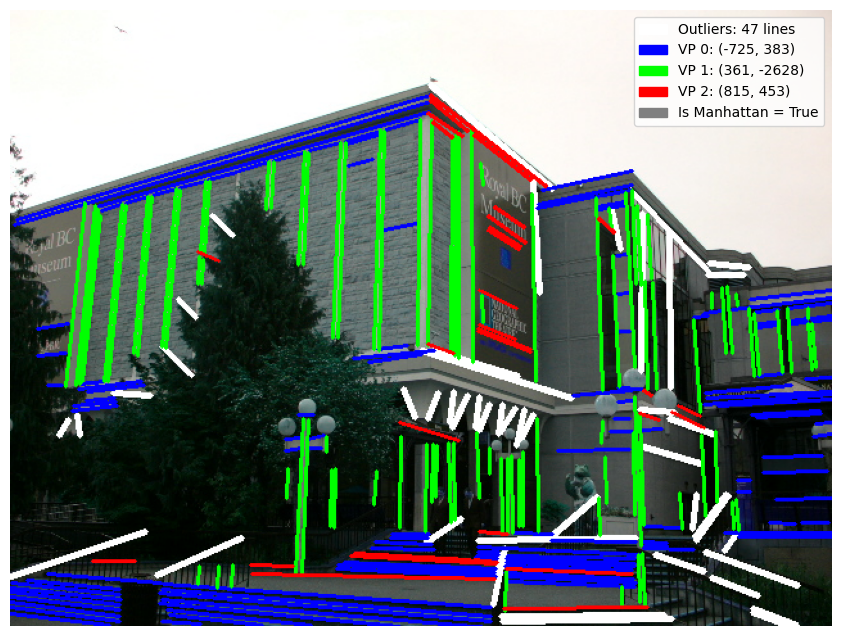

In [11]:
display_vanishing_points(image_real, line_segments, vps, labeling, display_outliers=True, is_manhattan=is_manhattan)

In [12]:
save_vanishing_points(image_real, line_segments, vps, labeling, output_path, filename_real, display_outliers=True, is_manhattan=is_manhattan)

In [13]:
is_manhattan_gen, vps_gen, labeling_gen, line_segments_gen, (dot01_gen, dot12_gen, dot20_gen) = pipeline(image_generated, K_geolib_gen,
                                                                                                        line_detector='deeplsd',
                                                                                                        vp_threshold=1.0,
                                                                                                        refinement_threshold=0.75,
                                                                                                        manhattan_threshold=0.15,
                                                                                                        do_refinement=True, verbose=False,
                                                                                                        refinement_stragegy='search_optimal')

Drawing the lines assigned to the outliers. Label: 3
# inliers = 154
vanishing_points[idx]: [  317 15980] <class 'numpy.ndarray'>
Drawing the lines assigned to the 1-th vanishing point.
# inliers = 302
vanishing_points[idx]: [-648  430] <class 'numpy.ndarray'>
Drawing the lines assigned to the 2-th vanishing point.
# inliers = 155
vanishing_points[idx]: [1801  494] <class 'numpy.ndarray'>
Drawing the lines assigned to the 3-th vanishing point.
# inliers = 37


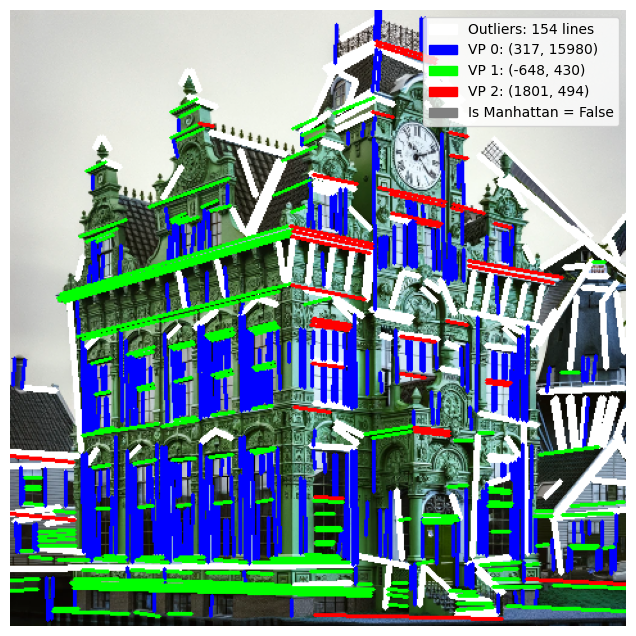

In [14]:
display_vanishing_points(image_generated, line_segments_gen, vps_gen, labeling_gen, display_outliers=True, is_manhattan=is_manhattan_gen)

In [15]:
save_vanishing_points(image_generated, line_segments_gen, vps_gen, labeling_gen, output_path, filename_generated, display_outliers=True, is_manhattan=is_manhattan_gen)